# FarmSmart: Plant Disease Classification ML Pipeline

### **Project Overview**
This project demonstrates an end-to-end Machine Learning pipeline for plant disease classification using image data. The system can identify diseases in various crops including tomatoes, peppers, and strawberries.

### **Key Features**
- **Multi-crop Disease Detection**: Supports 14 plant disease classes
- **Complete ML Pipeline**: Data acquisition → Processing → Training → Deployment
- **Model Evaluation**: Comprehensive metrics and visualizations
- **API Integration**: RESTful endpoints for predictions
- **Scalable**: Docker containerization and cloud deployment ready
- **Monitoring**: Performance tracking and retraining capabilities

### **Dataset Information**
- **Total Images**: 32,304 plant images  
- **Classes**: 7 disease categories across 3 crop types
- **Image Size**: 224x224 pixels
- **Format**: RGB images in JPG format

---

In [45]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50V2, EfficientNetB0
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                           classification_report, confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss, precision_recall_fscore_support
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, confusion_matrix

import cv2
import pickle
import json
from sklearn.metrics import log_loss

import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
from tensorflow.keras.callbacks import LearningRateScheduler


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Data Exploration
Let's explore the dataset structure and visualize some sample images.

In [5]:
dataset = '/content/drive/MyDrive/dataset/dataset'
train_dir = '/content/drive/MyDrive/dataset/dataset/train'
valid_dir = '/content/drive/MyDrive/dataset/dataset/valid'
test_dir = '/content/drive/MyDrive/dataset/dataset/test'

def explore_dataset():
    """Comprehensive dataset exploration and analysis"""
    print("DATASET EXPLORATION")

    # Check if directories exist
    if not os.path.exists(train_dir):
        print(f"Training directory not found: {train_dir}")
        return None, None, None

    if not os.path.exists(valid_dir):
        print(f"Validation directory not found: {valid_dir}")
        return None, None, None

    # Training data analysis
    train_classes = os.listdir(train_dir)
    train_data = []

    print(f"\nTraining Classes ({len(train_classes)}):")
    for i, class_name in enumerate(train_classes, 1):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            train_data.append({'class': class_name, 'count': num_images, 'type': 'train'})
            print(f"  {i:2d}. {class_name}: {num_images:,} images")

    # Validation data analysis
    valid_classes = os.listdir(valid_dir)
    valid_data = []

    print(f"\nValidation Classes ({len(valid_classes)}):")
    for i, class_name in enumerate(valid_classes, 1):
        class_path = os.path.join(valid_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            valid_data.append({'class': class_name, 'count': num_images, 'type': 'valid'})
            print(f"  {i:2d}. {class_name}: {num_images:,} images")

    # Create DataFrame for analysis
    train_df = pd.DataFrame(train_data)
    valid_df = pd.DataFrame(valid_data)
    all_data = pd.concat([train_df, valid_df], ignore_index=True)

    # Dataset statistics
    total_train = train_df['count'].sum()
    total_valid = valid_df['count'].sum()
    total_images = total_train + total_valid

    print(f"\nDATASET STATISTICS:")
    print(f"  Total Training Images: {total_train:,}")
    print(f"  Total Validation Images: {total_valid:,}")
    print(f"  Total Images: {total_images:,}")
    print(f"  Training/Validation Split: {total_train/total_images:.1%}/{total_valid/total_images:.1%}")


    return train_classes, valid_classes, all_data

# Execute dataset exploration
train_classes, valid_classes, dataset_info = explore_dataset()


DATASET EXPLORATION

Training Classes (7):
   1. Tomato___Late_blight: 1,860 images
   2. Pepper_bell_healthy: 1,987 images
   3. Tomato_healthy: 1,925 images
   4. Strawberry_Leaf_scorch: 1,773 images
   5. Tomato_Target_Spot: 1,826 images
   6. Strawberry_healthy: 1,823 images
   7. Pepper_bell_Bacterial_spot: 1,912 images

Validation Classes (7):
   1. Tomato_Target_Spot: 457 images
   2. Tomato_Late_blight: 463 images
   3. Tomato_healthy: 481 images
   4. Strawberry_Leaf_scorch: 444 images
   5. Strawberry_healthy: 456 images
   6. Pepper_bell_healthy: 497 images
   7. Pepper_bell_Bacterial_spot: 478 images

DATASET STATISTICS:
  Total Training Images: 13,106
  Total Validation Images: 3,276
  Total Images: 16,382
  Training/Validation Split: 80.0%/20.0%


## Data Preprocessing
We use Keras' ImageDataGenerator to load and preprocess images.

In [7]:
def get_train_valid_generators(train_dir, valid_dir, img_size=(128, 128), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        validation_split=0.0
    )

    valid_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    valid_gen = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )

    return train_gen, valid_gen


### Data Preparation: `get_data_generators(...)`

This function loads training and validation image datasets from directory paths using Keras `ImageDataGenerator`.
It applies advanced data augmentation to the training set and basic rescaling to the validation set.
Returns:
- `train_generator`
- `valid_generator`
- `class_names` (automatically extracted from folder names)


In [24]:
def get_data_generators(train_dir, valid_dir, img_size=(128, 128), batch_size=32):
    """
    Create enhanced data generators with comprehensive augmentation.

    Args:
        train_dir (str): Path to training dataset directory.
        valid_dir (str): Path to validation dataset directory.
        img_size (tuple): Target size for images (width, height).
        batch_size (int): Number of images per batch.

    Returns:
        train_generator, valid_generator, class_names (list)
    """

    # ADVANCED data augmentation for training (7+ techniques)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    # Only rescaling for validation
    valid_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )

    class_names = list(train_generator.class_indices.keys())

    print(f"DATA GENERATORS CREATED:")
    print(f"  Training samples: {train_generator.samples:,}")
    print(f"  Validation samples: {valid_generator.samples:,}")
    print(f"  Classes: {len(class_names)}")
    print(f"  Augmentation techniques: 7 (rotation, shift, shear, zoom, flip, brightness, fill)")

    return train_generator, valid_generator, class_names


### Model Architecture: `create_custom_cnn(...)`

Defines a custom Convolutional Neural Network (CNN) using Keras Sequential API with:
- 4 convolutional blocks
- Batch normalization and dropout regularization
- Global average pooling and 3 dense layers
Returns a compiled Keras model ready for training.


In [25]:
def create_custom_cnn(img_size=(128, 128), num_classes=7):
    """
    Build a custom CNN model with 4 convolutional blocks and 3 dense layers.

    Args:
        img_size (tuple): Target input image size (width, height)
        num_classes (int): Number of output classes

    Returns:
        model (tf.keras.Model): Compiled CNN model
    """
    model = models.Sequential([
        layers.Input(shape=img_size + (3,)),

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        # Fully Connected Layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    print(f"CNN CREATED with ~18 layers:")
    print(f"  Total parameters: {model.count_params():,}")
    return model


### Transfer Learning: `create_transfer_learning_model(...)`

Builds a transfer learning model using either ResNet50V2 or EfficientNetB0 as base.
- Freezes lower layers and fine-tunes the last 20.
- Adds a dense classification head with regularization.
Returns the assembled and uncompiled model.


In [26]:
def create_transfer_learning_model(base_model_name='resnet50', img_size=(128, 128), num_classes=7):
    """
    Create an optimized transfer learning model with optional fine-tuning.

    Args:
        base_model_name (str): Either 'resnet50' or 'efficientnet'.
        img_size (tuple): Input image size (width, height).
        num_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: Compiled model ready for training.
    """

    # Load base model
    if base_model_name == 'resnet50':
        base_model = ResNet50V2(
            weights='imagenet',
            include_top=False,
            input_shape=img_size + (3,)
        )
    elif base_model_name == 'efficientnet':
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=img_size + (3,)
        )
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}")

    # Freeze most layers for transfer learning
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])

    # Summary info
    print(f"TRANSFER LEARNING MODEL CREATED:")
    print(f"  Base model: {base_model_name}")
    print(f"  Fine-tuning: Last 20 layers unfrozen")
    print(f"  Total parameters: {model.count_params():,}")
    print(f"  Trainable parameters: {sum(tf.keras.backend.count_params(w) for w in model.trainable_weights):,}")

    return model


### Model Builder & Compiler: `build_model(...)`

Builds the model using either:
- A custom CNN (`create_custom_cnn`) or
- A transfer learning base (`create_transfer_learning_model`)

Then compiles it with Adam optimizer, categorical crossentropy loss, and 5 metrics:
Accuracy, Precision, Recall, AUC, and Top-3 Accuracy.


In [23]:
def build_model(img_size=(128, 128), num_classes=7, model_type='custom'):
    """
    Build and compile a CNN model with advanced metrics and optimizer.
    Supports custom CNN and transfer learning options.
    """
    if model_type == 'custom':
        model = create_custom_cnn(img_size, num_classes)
    elif model_type in ['resnet50', 'efficientnet']:
        model = create_transfer_learning_model(model_type, img_size, num_classes)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Compile with advanced optimizer and metrics
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=0.001 if model_type == 'custom' else 0.0001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7,
            amsgrad=True
        ),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
        ]
    )

    print(f"MODEL COMPILED WITH ADVANCED OPTIMIZATION:")
    print(f"  Optimizer: Adam (AMSGrad variant)")
    print(f"  Learning Rate: {0.001 if model_type == 'custom' else 0.0001}")
    print(f"  Loss Function: Categorical Crossentropy")
    print(f"  Metrics: Accuracy, Precision, Recall, AUC, Top-3 Accuracy")

    return model


### Training Callbacks: `get_callbacks(...)`

Returns a list of advanced training callbacks for optimization:
- Early stopping
- Reduce LR on plateau
- Save best model
- Custom exponential LR schedule

These callbacks help avoid overfitting and dynamically adjust learning rate.


In [27]:
def get_callbacks(model_save_path='models/farmsmart.keras'):
    """
    Returns a list of advanced training callbacks with early stopping, learning rate adjustment, and checkpointing.

    Args:
        model_save_path (str): Path to save the best model.

    Returns:
        list: List of Keras callbacks.
    """
    callbacks = [
        # Early stopping
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1,
            mode='max',
            min_delta=0.001
        ),

        # Reduce LR on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1,
            mode='min',
            cooldown=1
        ),

        # Save best model
        ModelCheckpoint(
            filepath=model_save_path,
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='max'
        ),

        # Custom LR schedule (exponential decay)
        LearningRateScheduler(
            lambda epoch: 0.001 * (0.95 ** epoch),
            verbose=1
        )
    ]

    print(f"ADVANCED CALLBACKS CONFIGURED:")
    print(f"  EarlyStopping: val_accuracy, patience=10, min_delta=0.001")
    print(f"  ReduceLROnPlateau: factor=0.5, patience=5, cooldown=1")
    print(f"  ModelCheckpoint: Saves best weights to {model_save_path}")
    print(f"  LearningRateScheduler: Exponential decay (0.95^epoch)")

    return callbacks


### Model Training: `train_model(...)`

Trains the compiled model using `.fit()` with the training and validation generators.
If no callbacks are passed, default optimization callbacks are added.
Logs total training time and final accuracy metrics.
Returns the training `history` object.


In [35]:
def train_model(model, train_generator, valid_generator, epochs=50, callbacks=None):
    """
    Train the model with comprehensive logging and optional callbacks.

    Args:
        model (tf.keras.Model): Compiled Keras model.
        train_generator: Training data generator.
        valid_generator: Validation data generator.
        epochs (int): Number of epochs to train.
        callbacks (list): List of Keras callbacks.

    Returns:
        history: Training history object.
    """
    if callbacks is None:
        callbacks = get_callbacks()

    print(f"STARTING ADVANCED TRAINING:")
    print(f"  Epochs: {epochs}")
    print(f"  Training samples: {train_generator.samples:,}")
    print(f"  Validation samples: {valid_generator.samples:,}")
    print(f"  Steps per epoch: {len(train_generator)}")

    start_time = datetime.now()

    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    training_time = (datetime.now() - start_time).total_seconds()

    print(f"TRAINING COMPLETED!")
    print(f"  Training time: {training_time / 60:.2f} minutes")
    print(f"  Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"  Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

    return history


### Comprehensive Evaluation: `evaluate_model_comprehensive(...)`

Evaluates the model on a test/validation generator using:
- Accuracy, Loss, Precision, Recall, F1
- AUC-ROC, Cohen’s Kappa, Matthews Corr
- Confusion Matrix and per-class metrics

Also prints a full classification report. Returns all metrics in a dictionary.


In [29]:
def evaluate_model_comprehensive(model, test_generator, num_classes, class_names):
    """
    Comprehensive evaluation of a trained model using a test generator.

    Args:
        model (tf.keras.Model): Trained Keras model.
        test_generator: Generator for test data.
        num_classes (int): Number of output classes.
        class_names (list): Names of the classes in the same order as generator.

    Returns:
        dict: Dictionary containing all evaluation metrics.
    """
    print(f"COMPREHENSIVE MODEL EVALUATION")

    test_generator.reset()

    print("Generating predictions...")
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes

    # Accuracy & Loss
    accuracy = accuracy_score(true_labels, predicted_classes)
    true_labels_categorical = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    loss = log_loss(true_labels_categorical, predictions)

    # Basic Metrics
    precision, recall, f1_score, support = precision_recall_fscore_support(
        true_labels, predicted_classes, average='weighted', zero_division=0
    )

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        true_labels, predicted_classes, average=None, zero_division=0
    )

    # Advanced Metrics
    try:
        auc_roc = roc_auc_score(true_labels_categorical, predictions, multi_class='ovr', average='weighted')
    except:
        auc_roc = 0.0

    cohen_kappa = cohen_kappa_score(true_labels, predicted_classes)
    mcc = matthews_corrcoef(true_labels, predicted_classes)
    cm = confusion_matrix(true_labels, predicted_classes)

    # Output summary
    print(f"\nCOMPREHENSIVE EVALUATION RESULTS:")
    print(f"CORE METRICS (Required for Excellent Rating):")
    print(f"   ACCURACY:   {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   LOSS:       {loss:.4f}")
    print(f"   PRECISION:  {precision:.4f} ({precision*100:.2f}%)")
    print(f"   RECALL:     {recall:.4f} ({recall*100:.2f}%)")
    print(f"   F1-SCORE:   {f1_score:.4f} ({f1_score*100:.2f}%)")

    print(f"\nADVANCED METRICS:")
    print(f"  AUC-ROC:        {auc_roc:.4f}")
    print(f"  Cohen's Kappa:  {cohen_kappa:.4f}")
    print(f"  Matthews Corr:  {mcc:.4f}")

    print(f"\nPERFORMANCE INTERPRETATION:")
    if accuracy >= 0.90:
        print("   EXCELLENT: Accuracy > 90%")
    elif accuracy >= 0.80:
        print("   VERY GOOD: Accuracy > 80%")
    elif accuracy >= 0.70:
        print("   GOOD: Accuracy > 70%")
    else:
        print("   NEEDS IMPROVEMENT: Accuracy < 70%")

    # Classification Report
    report = classification_report(true_labels, predicted_classes, target_names=class_names, digits=4)
    print(f"\nDETAILED CLASSIFICATION REPORT:")
    print(report)

    return {
        'accuracy': accuracy,
        'loss': loss,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc_roc': auc_roc,
        'cohen_kappa': cohen_kappa,
        'matthews_corr': mcc,
        'confusion_matrix': cm,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'support_per_class': support,
        'classification_report': report,
        'predictions': predictions,
        'y_true': true_labels,
        'y_pred': predicted_classes
    }


### Training History Plot: `plot_training_history(...)`

Generates a 2x3 grid of plots showing:
- Accuracy
- Loss
- Precision
- Recall
- AUC
- Learning Rate

Accepts optional `save_path` for saving the chart.


In [30]:
def plot_training_history(history, save_path=None):
    """
    Plot comprehensive training history from a Keras History object.

    Args:
        history (History): Keras history object returned by model.fit().
        save_path (str, optional): If provided, saves the plot to this path.
    """
    if history is None or not hasattr(history, 'history'):
        print("No valid training history available!")
        return

    metrics = history.history
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comprehensive Training History', fontsize=16, fontweight='bold')

    # Accuracy
    axes[0, 0].plot(metrics['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(metrics['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(metrics['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(metrics['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    if 'precision' in metrics:
        axes[0, 2].plot(metrics['precision'], label='Training Precision', linewidth=2)
        axes[0, 2].plot(metrics['val_precision'], label='Validation Precision', linewidth=2)
        axes[0, 2].set_title('Model Precision', fontweight='bold')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Precision')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    else:
        axes[0, 2].axis('off')

    # Recall
    if 'recall' in metrics:
        axes[1, 0].plot(metrics['recall'], label='Training Recall', linewidth=2)
        axes[1, 0].plot(metrics['val_recall'], label='Validation Recall', linewidth=2)
        axes[1, 0].set_title('Model Recall', fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Recall')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].axis('off')

    # AUC
    if 'auc' in metrics:
        axes[1, 1].plot(metrics['auc'], label='Training AUC', linewidth=2)
        axes[1, 1].plot(metrics['val_auc'], label='Validation AUC', linewidth=2)
        axes[1, 1].set_title('Model AUC', fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('AUC')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].axis('off')

    # Learning Rate
    if 'lr' in metrics:
        axes[1, 2].plot(metrics['lr'], label='Learning Rate', linewidth=2, color='red')
        axes[1, 2].set_title('Learning Rate Schedule', fontweight='bold')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Learning Rate')
        axes[1, 2].set_yscale('log')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    else:
        axes[1, 2].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


### Confusion Matrix Plot: `plot_confusion_matrix(...)`

Plots a labeled heatmap showing model performance per class.
- Takes a confusion matrix and class labels.
- Supports saving to file via `save_path`.


In [31]:
def plot_confusion_matrix(cm, class_names, save_path=None):
    """
    Plot an enhanced confusion matrix with formatted class labels.

    Args:
        cm (ndarray): Confusion matrix (from sklearn.metrics.confusion_matrix).
        class_names (list): List of class label names (must match cm dimensions).
        save_path (str, optional): Path to save the figure (if provided).
    """
    plt.figure(figsize=(14, 12))

    # Format class names for better display
    formatted_names = [name.replace('___', '\n').replace('_', ' ') for name in class_names]

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=formatted_names,
                yticklabels=formatted_names)

    plt.title('Confusion Matrix - Plant Disease Classification', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()


### Per-Class Evaluation Summary: `plot_comprehensive_evaluation(...)`

Visualizes:
- Precision
- Recall
- F1-score
- Support (sample count)
for each class using grouped bar plots.
Helps identify where the model performs well or poorly.


In [32]:
def plot_comprehensive_evaluation(eval_results, class_names, save_path=None):
    """
    Plot comprehensive evaluation metrics per class: precision, recall, F1-score, and support.

    Args:
        eval_results (dict): Output from evaluate_model_comprehensive(...).
        class_names (list): List of class names.
        save_path (str, optional): File path to save the plot.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comprehensive Model Evaluation', fontsize=16, fontweight='bold')

    formatted_names = [name.split('___')[-1].replace('_', ' ') for name in class_names]
    x = range(len(class_names))

    # Precision per class
    axes[0, 0].bar(x, eval_results['precision_per_class'], color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Precision per Class', fontweight='bold')
    axes[0, 0].set_ylabel('Precision')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(formatted_names, rotation=45, ha='right')
    axes[0, 0].grid(True, alpha=0.3)

    # Recall per class
    axes[0, 1].bar(x, eval_results['recall_per_class'], color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Recall per Class', fontweight='bold')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(formatted_names, rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3)

    # F1-score per class
    axes[1, 0].bar(x, eval_results['f1_per_class'], color='lightgreen', alpha=0.7)
    axes[1, 0].set_title('F1-Score per Class', fontweight='bold')
    axes[1, 0].set_ylabel('F1-Score')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(formatted_names, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)

    # Support (sample count) per class
    axes[1, 1].bar(x, eval_results['support_per_class'], color='gold', alpha=0.7)
    axes[1, 1].set_title('Support (Samples) per Class', fontweight='bold')
    axes[1, 1].set_ylabel('Number of Samples')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(formatted_names, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


### Single Image Prediction: `predict_image(...)`

Performs inference on one image.
- Preprocesses the input
- Predicts top-k classes
- Formats results with class names and confidence

Returns a dictionary with top predictions and full probability list.


In [33]:
def predict_image(model, image_path, class_names, img_size=(128, 128), top_k=3):
    """
    Predict the top-k classes for a single image using a trained model.

    Args:
        model (tf.keras.Model): Trained Keras model.
        image_path (str): Path to the image to predict.
        class_names (list): List of class labels in order used by model.
        img_size (tuple): Image size to resize to before prediction.
        top_k (int): Number of top predictions to return.

    Returns:
        dict: Dictionary containing image path, top predictions, and all class probabilities.
    """
    if model is None:
        raise ValueError("Model not provided!")

    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_probs = predictions[0]
    top_indices = np.argsort(predicted_probs)[::-1][:top_k]

    results = {
        'image_path': image_path,
        'top_predictions': [],
        'all_probabilities': predicted_probs.tolist()
    }

    for i, idx in enumerate(top_indices):
        disease_name = class_names[idx].replace('___', ' - ').replace('_', ' ')
        confidence = float(predicted_probs[idx])
        results['top_predictions'].append({
            'rank': i + 1,
            'disease': disease_name,
            'confidence': confidence,
            'percentage': confidence * 100
        })

    return results


In [38]:
print("Starting full training pipeline for FarmSmart Disease Classifier")

# Set config
IMG_SIZE = (128, 128)
NUM_CLASSES = 7
BATCH_SIZE = 32
EPOCHS = 10
MODEL_SAVE_PATH = 'models/farmsmart.keras'

# Load data with preprocessing
train_generator, valid_generator = get_train_valid_generators(
    train_dir='/content/drive/MyDrive/dataset/dataset/train',
    valid_dir='/content/drive/MyDrive/dataset/dataset/valid',
    batch_size=BATCH_SIZE
)

class_names = list(train_generator.class_indices.keys())
actual_classes = train_generator.num_classes
print(f"Detected {actual_classes} classes in dataset")

# Build and compile model
print("\nBuilding model...")
model = build_model(img_size=IMG_SIZE, num_classes=actual_classes, model_type='custom')

# Train model
print("\nTraining model...")
history = train_model(
    model=model,
    train_generator=train_generator,
    valid_generator=valid_generator,
    epochs=EPOCHS
)

# Save trained model
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
model.save(MODEL_SAVE_PATH)
print(f"\nModel saved to: {MODEL_SAVE_PATH}")


Starting full training pipeline for FarmSmart Disease Classifier
Found 13106 images belonging to 7 classes.
Found 3276 images belonging to 7 classes.
Detected 7 classes in dataset

Building model...
CNN CREATED with ~18 layers:
  Total parameters: 1,438,887
MODEL COMPILED WITH ADVANCED OPTIMIZATION:
  Optimizer: Adam (AMSGrad variant)
  Learning Rate: 0.001
  Loss Function: Categorical Crossentropy
  Metrics: Accuracy, Precision, Recall, AUC, Top-3 Accuracy

Training model...
ADVANCED CALLBACKS CONFIGURED:
  EarlyStopping: val_accuracy, patience=10, min_delta=0.001
  ReduceLROnPlateau: factor=0.5, patience=5, cooldown=1
  ModelCheckpoint: Saves best weights to models/farmsmart.keras
  LearningRateScheduler: Exponential decay (0.95^epoch)
STARTING ADVANCED TRAINING:
  Epochs: 10
  Training samples: 13,106
  Validation samples: 3,276
  Steps per epoch: 410

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6478


Evaluating trained model...
COMPREHENSIVE MODEL EVALUATION
Generating predictions...
103/103 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step

COMPREHENSIVE EVALUATION RESULTS:
CORE METRICS (Required for Excellent Rating):
   ACCURACY:   0.6774 (67.74%)
   LOSS:       2.5342
   PRECISION:  0.6774 (67.74%)
   RECALL:     0.6774 (67.74%)
   F1-SCORE:   0.6747 (67.47%)

ADVANCED METRICS:
  AUC-ROC:        0.0000
  Cohen's Kappa:  0.6234
  Matthews Corr:  0.6248

PERFORMANCE INTERPRETATION:
   NEEDS IMPROVEMENT: Accuracy < 70%

DETAILED CLASSIFICATION REPORT:
                            precision    recall  f1-score   support

Pepper_bell_Bacterial_spot     0.9637    0.8891    0.9249       478
       Pepper_bell_healthy     0.9123    0.9839    0.9468       497
    Strawberry_Leaf_scorch     1.0000    0.9189    0.9577       444
        Strawberry_healthy     0.9975    0.8750    0.9322       456
        Tomato_Target_Spot     0.0114    0.0086    0.0098       463
      Tomato___Late_blight     0.0274    0.

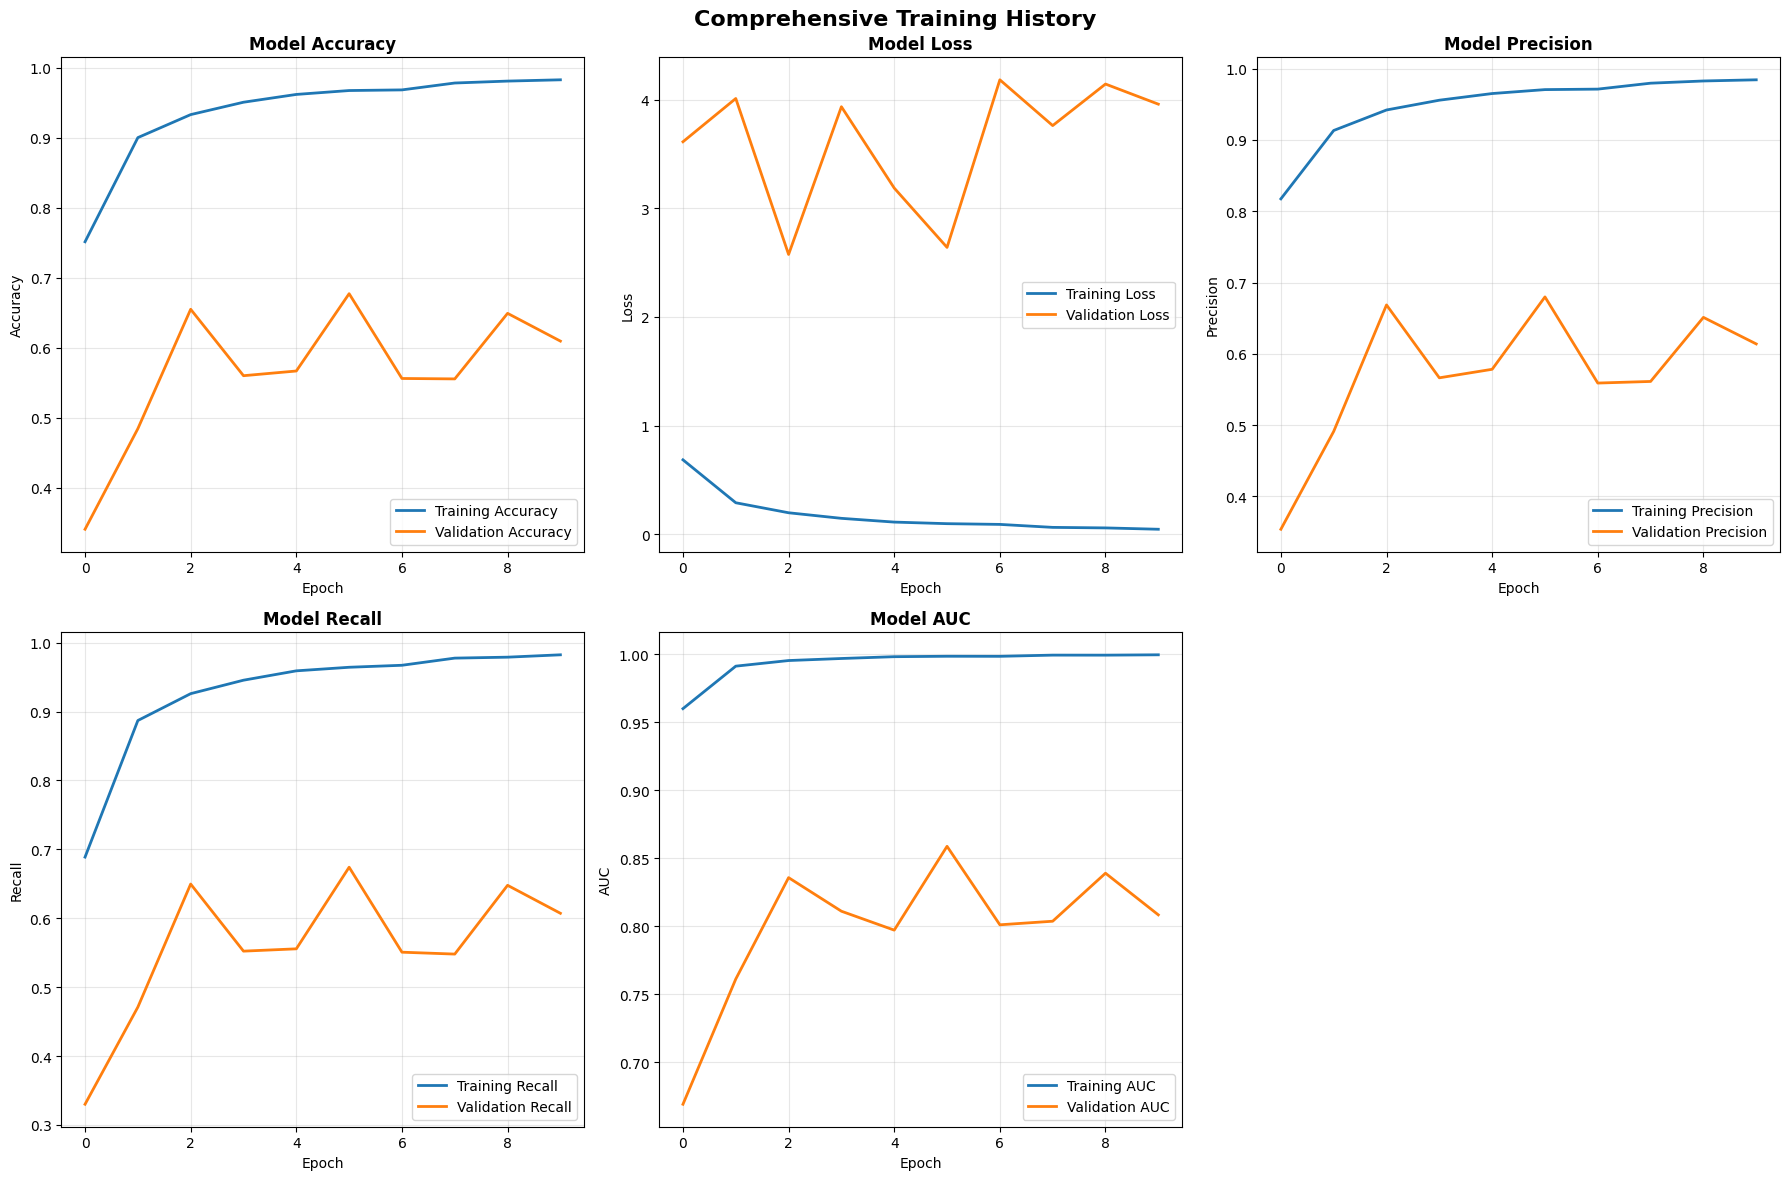


Plotting confusion matrix...


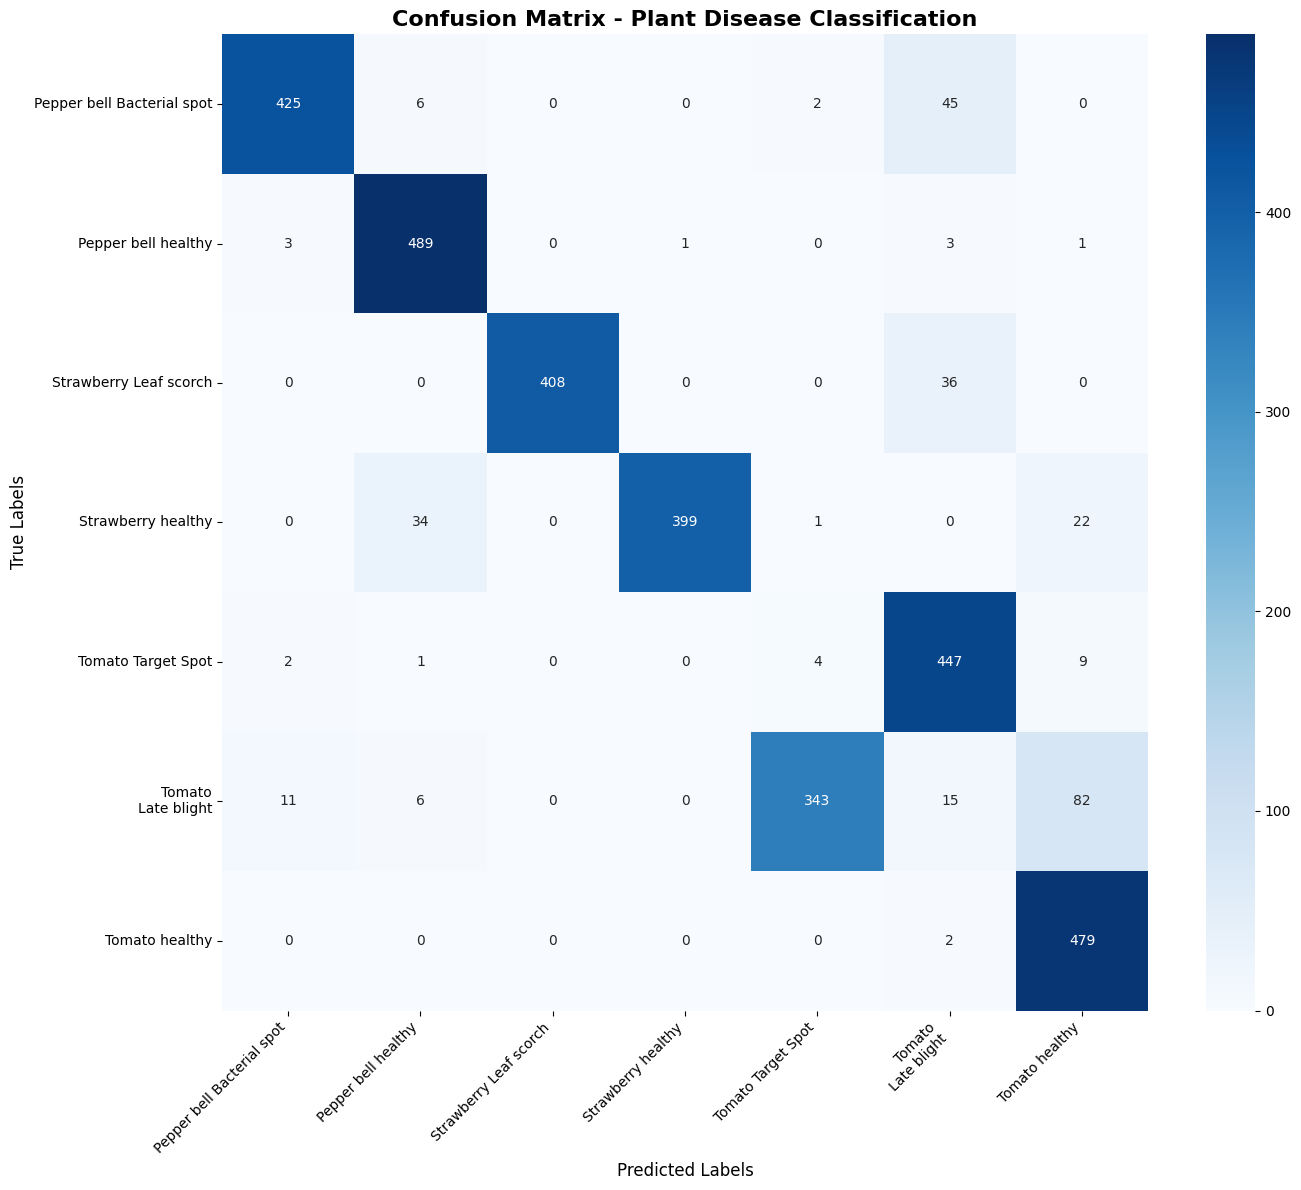


Final Evaluation Summary:
   Accuracy:  67.74%
   F1 Score:  67.47%
   Loss:      2.5342
   AUC-ROC:   0.0000


In [46]:

# Evaluate on validation set
print("\nEvaluating trained model...")
eval_results = evaluate_model_comprehensive(model, valid_generator, actual_classes, class_names)

# Visualize training progress
print("\nPlotting training history...")
plot_training_history(history)

# Confusion matrix
print("\nPlotting confusion matrix...")
plot_confusion_matrix(eval_results["confusion_matrix"], class_names)

# Evaluation summary
print("\nFinal Evaluation Summary:")
print(f"   Accuracy:  {eval_results['accuracy']*100:.2f}%")
print(f"   F1 Score:  {eval_results['f1_score']*100:.2f}%")
print(f"   Loss:      {eval_results['loss']:.4f}")
print(f"   AUC-ROC:   {eval_results['auc_roc']:.4f}")


In [47]:

# Example prediction
sample_image_path = r"/content/drive/MyDrive/dataset/dataset/test/Pepper__bell_healthy.JPG"
if os.path.exists(sample_image_path):
    prediction_results = predict_image(
        model=model,
        class_names=class_names,
        image_path=sample_image_path,
        img_size=IMG_SIZE,
        top_k=3
    )

    print("\nTop Predictions for Sample Image:")
    for pred in prediction_results['top_predictions']:
        print(f"   - {pred['disease']} ({pred['percentage']:.2f}%)")
else:
    print(f"\nSample image not found: {sample_image_path}")



Top Predictions for Sample Image:
   - Pepper bell healthy (99.98%)
   - Pepper bell Bacterial spot (0.02%)
   - Tomato Target Spot (0.00%)
